# Churn Prediction Analysis

<h2>Churn Definition Rationale</h2>
<p>	For the purpose of this project, I defined churned customers as those with no recorded payments for 90 or more consecutive days. In this context, “no interaction” is interpreted as a lack of payment activity, which serves as a proxy for customer disengagement.</p>

<h4>Other Considerations but I didn't move forward with</h4>

<div class="alternative">
 <h5> Contract-Specific Thresholds for interaction window</h5>
 <p><strong>Benefits:</strong> Rather than using a generic threshold of 90 days for all customers, Month-to-month customers can have shorter thresholds, while one-year and two-year customers can have increasingly longer thresholds aligned with their expected interaction patterns</p>
 <p><strong>Decision rationale:</strong> Preserving contract type as a predictor outweighed the benefits of tailored thresholds, as using contract type in both churn definition and prediction would create data leakage, compromising model integrity</p>
</div>

<div class="alternative">
 <h5> Payment-Based Churn Definition</h5>
 <p><strong>Approach considered:</strong> Calculate total charges devided by monthly charges to derive paid months, then comparing with tenure to identify missed payments months</p>
 <p><strong>Decision rationale:</strong> We're not sure if monthly charges is based on the fixed contract plan or usage. It may change over time.</p>
</div>

<div class="note">
 <p><em>Note: The more complex the label construction is, the fewer features remain available for prediction, as features used in label creation cannot be used as predictors without creating data leakage. Therefore I decided to go with a simple label</em></p>
</div>

<h2>Exploratory Data Analysis</h2>

<h3>Customer Inactivity Overview</h3>
<ul>
  <li><strong>37.27%</strong> (559 customers) are considered <strong>inactive/churned</strong> (no payment in 90+ days)</li>
  <li><strong>62.73%</strong> (941 customers) are <strong>active</strong> (made a payment within the last 90 days)</li>
</ul>

<h3>Feature Analysis between churned vs active customers</h3>

<table border="1" cellspacing="0" cellpadding="6">
  <thead>
    <tr>
      <th>Feature</th>
      <th>Type</th>
      <th>Max Distribution Difference (%)</th>
      <th>Mean Difference (%)</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Gender</td>
      <td>Categorical</td>
      <td>3.39</td>
      <td>NaN</td>
    </tr>
    <tr>
      <td>Internet Service</td>
      <td>Categorical</td>
      <td>2.01</td>
      <td>NaN</td>
    </tr>
    <tr>
      <td>Contract Type</td>
      <td>Categorical</td>
      <td>2.72</td>
      <td>NaN</td>
    </tr>
    <tr>
      <td>Payment Method</td>
      <td>Categorical</td>
      <td><strong>4.20</strong></td>
      <td>NaN</td>
    </tr>
    <tr>
      <td>Age</td>
      <td>Numerical</td>
      <td>NaN</td>
      <td>0.17</td>
    </tr>
    <tr>
      <td>Tenure (months)</td>
      <td>Numerical</td>
      <td>NaN</td>
      <td>1.40</td>
    </tr>
    <tr>
      <td>Monthly Charges</td>
      <td>Numerical</td>
      <td>NaN</td>
      <td>1.51</td>
    </tr>
  </tbody>
</table>

<h3>Key Findings</h3>
<ol>
  <li>Most features show minimal differences between active and inactive customers</li>
  <li><strong>Payment Method</strong> shows the largest difference, with Electronic check users being slightly more likely to be inactive (+4.20%)</li>
  <li><strong>Contract Type</strong> shows some minor differences, with one-year contract holders slightly more likely to be inactive (+2.72%)</li>
  <li>Other features (Age, Gender, Internet Service, Tenure, Charges) show barely any difference</li>
  <li><strong>Conclusion:</strong> Features in this dataset have limited predictive power for customer inactivity</li>
</ol>

Analyzing customer data to determine predictive power of features for 90+ day inactivity...
Total customers: 1500
Inactive customers (90+ days): 559 (37.27%)
Active customers (<90 days): 941 (62.73%)

Feature Importance Analysis:
         Feature        Type  Max Distribution Difference (%)  Mean Difference (%)
          Gender Categorical                         3.385619                  NaN
Internet Service Categorical                         2.014756                  NaN
   Contract Type Categorical                         2.722905                  NaN
  Payment Method Categorical                         4.203460                  NaN
             Age   Numerical                              NaN             0.167614
 Tenure (months)   Numerical                              NaN             1.398631
 Monthly Charges   Numerical                              NaN             1.510949


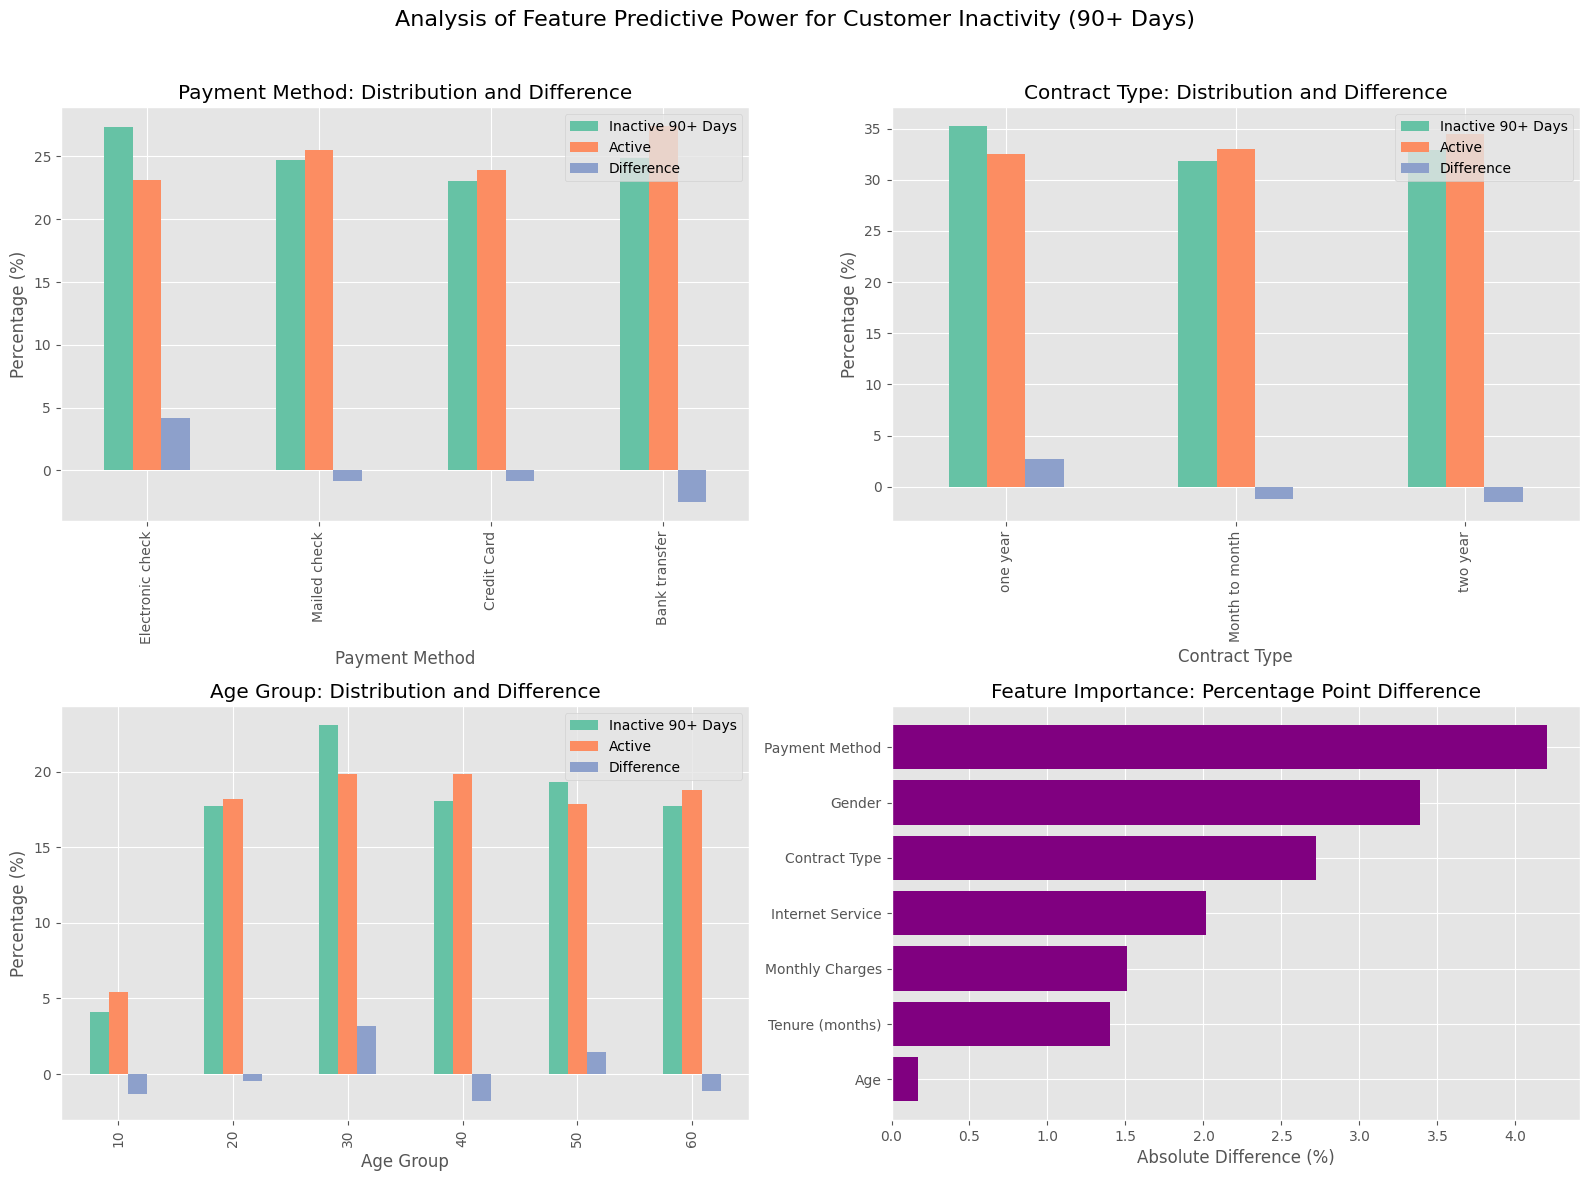

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re

# Set the style
plt.style.use('ggplot')
sns.set_palette("Set2")

# Function to load and preprocess data
def load_and_preprocess_data(file_path, current_date='2024-04-01'):
    """
    Load and preprocess the customer data.
    
    Parameters:
    -----------
    file_path : str
        Path to the CSV file
    current_date : str
        Current date in YYYY-MM-DD format
        
    Returns:
    --------
    df : pandas.DataFrame
        Preprocessed dataframe
    """
    # Load the data
    df = pd.read_csv(file_path)
    
    # Convert date strings to datetime objects
    current_date = datetime.strptime(current_date, '%Y-%m-%d')
    
    # Parse the Last Interaction dates
    def parse_date(date_str):
        if pd.isna(date_str):
            return None
        
        try:
            # Handling MM/DD/YYYY format
            return datetime.strptime(date_str, '%m/%d/%Y')
        except ValueError:
            try:
                # Handling MM/DD/YY format
                date = datetime.strptime(date_str, '%m/%d/%y')
                # Check if the year makes sense, adjust if needed
                if date.year > 2030:
                    date = date.replace(year=date.year - 100)
                return date
            except ValueError:
                return None
    
    df['Last Interaction Date'] = df['Last Interaction'].apply(parse_date)
    
    # Calculate days since last interaction
    df['Days Since Interaction'] = (current_date - df['Last Interaction Date']).dt.days
    
    # Create a flag for 90+ days of inactivity
    df['Inactive 90 Plus Days'] = df['Days Since Interaction'] >= 90
    
    # Clean up monetary values
    def clean_monetary(value):
        if isinstance(value, str):
            return float(re.sub(r'[^\d.]', '', value))
        return value
    
    df['Monthly Charges'] = df['Monthly Charges'].apply(clean_monetary)
    df['Total Charges'] = df['Total Charges'].apply(clean_monetary)
    
    return df

# Function to analyze feature distributions
def analyze_feature_distributions(df, feature, inactive_label='Inactive 90+ Days', active_label='Active'):
    """
    Analyze the distribution of a feature based on customer activity status.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The preprocessed dataframe
    feature : str
        The feature to analyze
    inactive_label : str
        Label for inactive customers
    active_label : str
        Label for active customers
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure containing the visualizations
    """
    inactive_df = df[df['Inactive 90 Plus Days']]
    active_df = df[~df['Inactive 90 Plus Days']]
    
    if df[feature].dtype == 'object' or len(df[feature].unique()) < 10:
        # For categorical features, create a comparison bar chart
        inactive_dist = inactive_df[feature].value_counts(normalize=True) * 100
        active_dist = active_df[feature].value_counts(normalize=True) * 100
        
        # Combine into a single dataframe for visualization
        comparison_df = pd.DataFrame({
            inactive_label: inactive_dist,
            active_label: active_dist
        })
        
        # Calculate the difference
        comparison_df['Difference'] = comparison_df[inactive_label] - comparison_df[active_label]
        
        # Create the figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        # Plot the distributions
        comparison_df[[inactive_label, active_label]].plot(kind='bar', ax=ax1)
        ax1.set_title(f'Distribution of {feature} by Activity Status')
        ax1.set_ylabel('Percentage')
        ax1.set_xlabel(feature)
        
        # Plot the differences
        comparison_df['Difference'].plot(kind='bar', ax=ax2, color='purple')
        ax2.set_title(f'Difference in {feature} Distribution (Inactive - Active)')
        ax2.set_ylabel('Percentage Point Difference')
        ax2.set_xlabel(feature)
        ax2.axhline(y=0, color='black', linestyle='-')
        
        # Add value labels to the bars
        for p in ax2.patches:
            ax2.annotate(f"{p.get_height():.2f}%", 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', 
                        xytext=(0, 10), 
                        textcoords='offset points')
        
    else:
        # For numerical features, create histograms
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        # Plot histograms
        sns.histplot(data=inactive_df, x=feature, kde=True, ax=ax1, color='red', label=inactive_label)
        sns.histplot(data=active_df, x=feature, kde=True, ax=ax1, color='blue', alpha=0.7, label=active_label)
        ax1.set_title(f'Distribution of {feature} by Activity Status')
        ax1.legend()
        
        # Create box plots
        combined_df = pd.DataFrame({
            'Value': pd.concat([inactive_df[feature], active_df[feature]]),
            'Status': pd.concat([pd.Series([inactive_label] * len(inactive_df)), 
                                pd.Series([active_label] * len(active_df))])
        })
        
        sns.boxplot(data=combined_df, x='Status', y='Value', ax=ax2)
        ax2.set_title(f'Box Plot of {feature} by Activity Status')
        
        # Add mean values to the box plot
        inactive_mean = inactive_df[feature].mean()
        active_mean = active_df[feature].mean()
        diff = inactive_mean - active_mean
        ax2.text(0, inactive_mean, f' Mean: {inactive_mean:.2f}', ha='left', va='center')
        ax2.text(1, active_mean, f' Mean: {active_mean:.2f}', ha='left', va='center')
        ax2.text(0.5, max(inactive_mean, active_mean) + (inactive_df[feature].max() - inactive_df[feature].min()) * 0.05, 
                f'Difference: {diff:.2f}', ha='center', va='center', fontweight='bold')
    
    plt.tight_layout()
    return fig

# Function to calculate feature importance metrics
def calculate_feature_importance(df):
    """
    Calculate crude feature importance metrics.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The preprocessed dataframe
        
    Returns:
    --------
    importance_df : pandas.DataFrame
        DataFrame with feature importance metrics
    """
    # Select features to analyze
    categorical_features = ['Gender', 'Internet Service', 'Contract Type', 'Payment Method']
    numerical_features = ['Age', 'Tenure (months)', 'Monthly Charges']
    
    results = []
    
    # Analyze categorical features
    for feature in categorical_features:
        inactive_dist = df[df['Inactive 90 Plus Days']][feature].value_counts(normalize=True)
        active_dist = df[~df['Inactive 90 Plus Days']][feature].value_counts(normalize=True)
        
        # Calculate the maximum absolute difference in distributions
        common_categories = set(inactive_dist.index) & set(active_dist.index)
        if common_categories:
            max_diff = max([abs(inactive_dist.get(cat, 0) - active_dist.get(cat, 0)) for cat in common_categories])
            max_diff_pct = max_diff * 100  # Convert to percentage
        else:
            max_diff_pct = 0
        
        results.append({
            'Feature': feature,
            'Type': 'Categorical',
            'Max Distribution Difference (%)': max_diff_pct,
            'Mean Difference (%)': None
        })
    
    # Analyze numerical features
    for feature in numerical_features:
        inactive_mean = df[df['Inactive 90 Plus Days']][feature].mean()
        active_mean = df[~df['Inactive 90 Plus Days']][feature].mean()
        
        # Calculate relative difference as a percentage
        mean_diff = abs(inactive_mean - active_mean)
        mean_diff_pct = (mean_diff / ((inactive_mean + active_mean) / 2)) * 100
        
        results.append({
            'Feature': feature,
            'Type': 'Numerical',
            'Max Distribution Difference (%)': None,
            'Mean Difference (%)': mean_diff_pct
        })
    
    # Create a DataFrame from the results
    importance_df = pd.DataFrame(results)
    
    return importance_df

# Main analysis function
def analyze_customer_inactivity(file_path, current_date='2024-04-01'):
    """
    Perform a comprehensive analysis of customer inactivity.
    
    Parameters:
    -----------
    file_path : str
        Path to the CSV file
    current_date : str
        Current date in YYYY-MM-DD format
        
    Returns:
    --------
    df : pandas.DataFrame
        The preprocessed dataframe
    """
    # Load and preprocess the data
    df = load_and_preprocess_data(file_path, current_date)
    
    # Print basic statistics
    print(f"Total customers: {len(df)}")
    inactive_count = df['Inactive 90 Plus Days'].sum()
    active_count = len(df) - inactive_count
    print(f"Inactive customers (90+ days): {inactive_count} ({inactive_count/len(df)*100:.2f}%)")
    print(f"Active customers (<90 days): {active_count} ({active_count/len(df)*100:.2f}%)")
    
    # Calculate feature importance
    importance_df = calculate_feature_importance(df)
    print("\nFeature Importance Analysis:")
    print(importance_df.to_string(index=False))
    
    return df, importance_df


def main(file_path='tele_data.csv'):
    """
    Run the complete analysis and demonstrate key findings.
    """
    # Load and analyze the data
    print("Analyzing customer data to determine predictive power of features for 90+ day inactivity...")
    df, importance_df = analyze_customer_inactivity(file_path)
    
    # Create a summary figure showing the most important findings
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Payment Method (strongest predictor)
    inactive_payment = df[df['Inactive 90 Plus Days']]['Payment Method'].value_counts(normalize=True) * 100
    active_payment = df[~df['Inactive 90 Plus Days']]['Payment Method'].value_counts(normalize=True) * 100
    payment_comp = pd.DataFrame({'Inactive 90+ Days': inactive_payment, 'Active': active_payment})
    payment_comp['Difference'] = payment_comp['Inactive 90+ Days'] - payment_comp['Active']
    payment_comp.sort_values('Difference', ascending=False).plot(kind='bar', ax=axs[0, 0])
    axs[0, 0].set_title('Payment Method: Distribution and Difference')
    axs[0, 0].set_ylabel('Percentage (%)')
    
    # Plot 2: Contract Type
    inactive_contract = df[df['Inactive 90 Plus Days']]['Contract Type'].value_counts(normalize=True) * 100
    active_contract = df[~df['Inactive 90 Plus Days']]['Contract Type'].value_counts(normalize=True) * 100
    contract_comp = pd.DataFrame({'Inactive 90+ Days': inactive_contract, 'Active': active_contract})
    contract_comp['Difference'] = contract_comp['Inactive 90+ Days'] - contract_comp['Active']
    contract_comp.sort_values('Difference', ascending=False).plot(kind='bar', ax=axs[0, 1])
    axs[0, 1].set_title('Contract Type: Distribution and Difference')
    axs[0, 1].set_ylabel('Percentage (%)')
    
    # Plot 3: Age distribution
    inactive_age = df[df['Inactive 90 Plus Days']].copy()
    inactive_age['Age Group'] = (inactive_age['Age'] // 10) * 10
    active_age = df[~df['Inactive 90 Plus Days']].copy()
    active_age['Age Group'] = (active_age['Age'] // 10) * 10
    
    inactive_age_dist = inactive_age['Age Group'].value_counts(normalize=True).sort_index() * 100
    active_age_dist = active_age['Age Group'].value_counts(normalize=True).sort_index() * 100
    
    age_comp = pd.DataFrame({'Inactive 90+ Days': inactive_age_dist, 'Active': active_age_dist})
    age_comp['Difference'] = age_comp['Inactive 90+ Days'] - age_comp['Active']
    age_comp.plot(kind='bar', ax=axs[1, 0])
    axs[1, 0].set_title('Age Group: Distribution and Difference')
    axs[1, 0].set_ylabel('Percentage (%)')
    axs[1, 0].set_xlabel('Age Group')


    # Plot 4: Feature importance summary
    features=importance_df['Feature']
    importance_values=importance_df['Max Distribution Difference (%)'].combine_first(importance_df['Mean Difference (%)'])

    # Sort by importances in descending order
    sorted_features, sorted_importances = zip(*sorted(
        zip(features, importance_values),
        key=lambda x: x[1],
        reverse=False
    ))


    axs[1, 1].barh(sorted_features, sorted_importances, color='purple')
    axs[1, 1].set_title('Feature Importance: Percentage Point Difference')
    axs[1, 1].set_xlabel('Absolute Difference (%)')
    
    # Add an overall title
    fig.suptitle('Analysis of Feature Predictive Power for Customer Inactivity (90+ Days)', 
                fontsize=16, y=0.98)
    
    # Adjust the layout to make room for the suptitle
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    return df, fig


<h2>Summary of Model Outcome for Customer Churn Prediction</h2>

<h3>Evaluated on the test dataset (20%) </h3>

<h3>Model Performance</h3>
<ul>
  <li><strong>AUC Score:</strong> 0.4639 — Worse than random (0.5), indicating the model struggles to distinguish churned from non-churned customers.</li>
  <li><strong>Accuracy:</strong> 50.67% — Barely above random guessing.</li>
  <li><strong>F1 Score:</strong> 0.3884 — Indicates poor balance between precision and recall.</li>
</ul>

<h3>Confusion Matrix Analysis</h3>
<ul>
  <li><strong>True Positives:</strong> 47 (correctly predicted churns)</li>
  <li><strong>False Positives:</strong> 83 (non-churns incorrectly predicted as churned)</li>
  <li><strong>True Negatives:</strong> 105 (correctly predicted non-churns)</li>
  <li><strong>False Negatives:</strong> 65 (missed actual churns)</li>
</ul>
<p>This shows substantial prediction errors in both directions — the model is misclassifying both churned and non-churned customers.</p>

<h3>Why the Model Performed Poorly</h3>
<ul>
  <li><strong>Weak feature signals:</strong> As shown in EDA, most features differed by less than 5% between churn groups.</li>
  <li><strong>data size is too small</strong> </li>
</ul>

<h3>Feature Importance Insights</h3>
<ul>
  <li>While I did examine feature importance and observed some patterns, the model’s poor performance suggests that these insights are likely unreliable. I would caution against drawing any conclusions from them.</li>
</ul>

<h3>Recommendations</h3>
<h4>Dataset Enrichment</h4>

<ul>
  <li><strong>Label Improvement:</strong> Although the current churn label (based on 90+ day inactivity) is a reasonable proxy, it may not fully capture true churn behavior.</li>
  <li><strong>Feature Enrichment: </strong></li>
  <li><strong>Support interactions:</strong> Complaints, ticket frequency, resolution times.</li>
  <li><strong>Usage activity:</strong> Data volume, login patterns, feature engagement.</li>
  <li><strong>Billing behavior:</strong> Late payments, autopay, refund history.</li>
  <li><strong>Tenure dynamics:</strong> Plan changes, upgrade/downgrade events.</li>
  <li><strong>Promotional engagement:</strong> Email/campaign responsiveness.</li>
</ul>

<h3>Business Insight</h3>
<p>The poor model performance actually validates the earlier hypothesis: basic demographic and account-level features <strong>alone</strong> are not sufficient to explain 90+ day inactivity. Churn is likely driven by <strong>behavioral, service quality, or contextual factors</strong> not present in this dataset.</p>


Churn Distribution: 559 churned, 941 not churned
Churn Rate: 37.27%
Scale Pos Weight for XGBoost: 1.68
Training set: 900 samples
Validation set: 300 samples
Test set: 300 samples

STARTING GRID SEARCH FOR HYPERPARAMETER TUNING
Performing Grid Search with 3-fold cross-validation...
Parameter grid: {'n_estimators': [5, 10, 50, 100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.05, 0.1], 'subsample': [0.8, 1.0], 'colsample_bytree': [0.8, 1.0], 'min_child_weight': [1, 3, 5], 'gamma': [0, 0.1, 0.2]}
This may take some time depending on the size of the parameter grid...
Fitting 3 folds for each of 1620 candidates, totalling 4860 fits

Grid Search completed in: 0:00:12

Best parameters found by grid search:
{'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 10, 'subsample': 0.8}
Best cross-validation AUC score: 0.5527

Top 5 parameter combinations:
Rank 1: Mean AUC: 0.5527 | Params: {'n_estimators': 10, 'max_depth': 7

/var/folders/15/15y2k03x62b75f7q08lgpfbm0000gn/T/ipykernel_91617/2652221452.py:218: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, feature_names=X.columns, show=False)


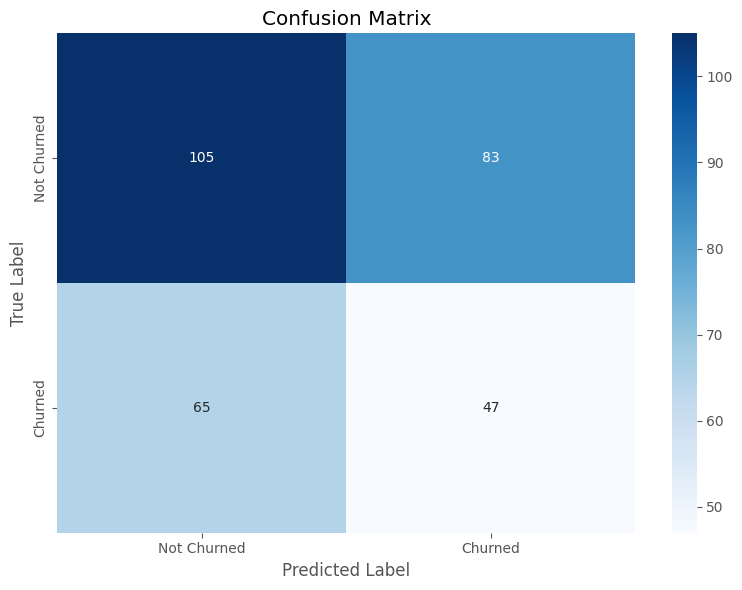

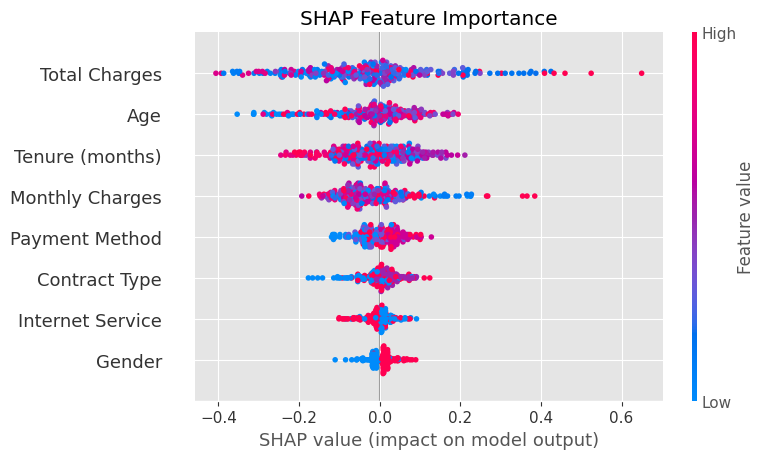

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, classification_report, confusion_matrix
import xgboost as xgb
import shap
import time
from datetime import timedelta

# Set random seed for reproducibility
np.random.seed(42)

# Load dataset
file_path = 'tele_data.csv'
data = pd.read_csv(file_path)

# Preprocessing
# Convert monetary values
data['Total Charges'] = data['Total Charges'].replace('[\$,]', '', regex=True).astype(float)
data['Monthly Charges'] = data['Monthly Charges'].replace('[\$,]', '', regex=True).astype(float)

# Convert dates and calculate days since last interaction
data['Last Interaction'] = pd.to_datetime(data['Last Interaction'])
reference_date = pd.to_datetime("4/1/2024")
data['Days Since Last Interaction'] = (reference_date - data['Last Interaction']).dt.days

# Define churn based on 90-day threshold
data['Churn'] = (data['Days Since Last Interaction'] >= 90).astype(int)

# Print churn distribution
churn_count = data['Churn'].sum()
total_count = len(data)
print(f"Churn Distribution: {churn_count} churned, {total_count - churn_count} not churned")
print(f"Churn Rate: {churn_count/total_count:.2%}")

# Calculate class weights for handling imbalance
scale_pos_weight = (total_count - churn_count) / churn_count
print(f"Scale Pos Weight for XGBoost: {scale_pos_weight:.2f}")

# Label encode categorical features
cat_cols = ['Gender', 'Internet Service', 'Contract Type', 'Payment Method']
for col in cat_cols:
    data[col] = LabelEncoder().fit_transform(data[col])

# Split data into features and target
X = data.drop(columns=['Customer ID', 'Last Interaction', 'Days Since Last Interaction', 'Churn'])
y = data['Churn']

# Split data into train+validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Further split into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)  # 0.25 x 0.8 = 0.2 of original data

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# --------------------------------
# Grid Search for Hyperparameter Tuning
# --------------------------------
print("\n" + "="*50)
print("STARTING GRID SEARCH FOR HYPERPARAMETER TUNING")
print("="*50)

# Define the parameter grid to search
param_grid = {
    'n_estimators': [5, 10, 50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2]
}

# Base XGBoost model with class imbalance handling
base_model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,  # Handle class imbalance
    eval_metric='auc',
    random_state=42
)

# Number of cross-validation folds
cv_folds = 3  # Using 3 folds for grid search to reduce computation time

# Set up GridSearchCV
print(f"Performing Grid Search with {cv_folds}-fold cross-validation...")
print(f"Parameter grid: {param_grid}")
print("This may take some time depending on the size of the parameter grid...")

start_time = time.time()

grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=cv_folds,
    scoring='roc_auc',
    n_jobs=-1,  # Use all available cores
    verbose=1
)

# Fit the grid search to the data
grid_search.fit(X_train_val, y_train_val)

# Display the time taken
end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nGrid Search completed in: {timedelta(seconds=int(elapsed_time))}")

# Get best parameters and score
print("\nBest parameters found by grid search:")
print(grid_search.best_params_)
print(f"Best cross-validation AUC score: {grid_search.best_score_:.4f}")

# Get top 5 parameter combinations
cv_results = pd.DataFrame(grid_search.cv_results_)
top_results = cv_results.sort_values('rank_test_score').head(5)
print("\nTop 5 parameter combinations:")
for i, row in top_results.iterrows():
    params = {key: row[f'param_{key}'] for key in param_grid.keys()}
    print(f"Rank {int(row['rank_test_score'])}: Mean AUC: {row['mean_test_score']:.4f} | Params: {params}")

# --------------------------------
# Train final model with best parameters
# --------------------------------
print("\n" + "="*50)
print("TRAINING FINAL MODEL WITH BEST PARAMETERS")
print("="*50)

# Create final model with best parameters
best_params = grid_search.best_params_
final_model = xgb.XGBClassifier(
    **best_params,
    scale_pos_weight=scale_pos_weight,  # Handle class imbalance
    eval_metric='auc',
    random_state=42
)

print("Best parameters being used:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

# Train the final model on the combined training+validation set
print("\nTraining final model on training and validation sets...")
final_model.fit(
    X_train_val, y_train_val,
    eval_set=[(X_train_val, y_train_val), (X_test, y_test)],
    verbose=False
)

# --------------------------------
# Evaluate the model
# --------------------------------
print("\n" + "="*50)
print("MODEL EVALUATION")
print("="*50)

# Get predictions on test set
y_test_pred = final_model.predict(X_test)
y_test_prob = final_model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
test_auc = roc_auc_score(y_test, y_test_prob)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print("\nTest Set Performance:")
print(f"AUC: {test_auc:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_test_pred)}")

# Print confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Churned', 'Churned'],
            yticklabels=['Not Churned', 'Churned'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
print("Confusion matrix saved as 'confusion_matrix.png'")

# --------------------------------
# Feature Importance Analysis
# --------------------------------
print("\n" + "="*50)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*50)

print("\n2. SHAP Feature Importance Analysis")
# Create a SHAP explainer
explainer = shap.TreeExplainer(final_model)

# Calculate SHAP values for test set
print("Calculating SHAP values (this may take a moment)...")
shap_values = explainer.shap_values(X_test)

# Summarize feature importance
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, feature_names=X.columns, show=False)
plt.title('SHAP Feature Importance')
plt.tight_layout()
plt.savefig('shap_feature_importance.png')
print("SHAP feature importance plot saved as 'shap_feature_importance.png'")

# Show top 10 features by mean absolute SHAP value
shap_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': np.abs(shap_values).mean(axis=0)
})
shap_importance = shap_importance.sort_values('Importance', ascending=False)

